In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os


#### Loading Data:

In [2]:
data = np.load('data.npy')
data.shape # 1315 gray scale images.

(1315, 224, 224, 3)

In [3]:
labels = np.load('labels.npy')
labels.shape #one hot labels.

(1315, 2)

In [4]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [5]:
#IMAGE AUGMENTATION:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

#### MOBILE V2NET ARCH MODEL:

In [6]:
#LOADING THE MOBILE V2NET ARCHITECTURE BUT WE DONT INCLUDE THE FULLY CONNECTED LAYERS.
#weights = 'imagenet' means loading the data with pre trained imagenet wts.
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [7]:
#CONSTRUCTING MODEL- HEAD (FC LAYERS ) TO BE PLACED ON TOP OF THE MODEL: FUNCTIONAL API
head_model = baseModel.output
head_model = AveragePooling2D(pool_size=(7,7))(head_model)
head_model = Flatten(name='Flatten')(head_model)
head_model = Dense(128,activation='relu')(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation="softmax")(head_model)

In [8]:
#PLACING THE HEAD MODEL ON TOP OF BASE MODEL:
model = Model(inputs=baseModel.input,outputs = head_model)

In [9]:
#FREEZING THE BASE MODEL LAYERS SO THAT THEY DONT GET UPDATED DURING TRAINING:
for layer in baseModel.layers:
	layer.trainable = False

In [10]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4 #LEARNING RATE - SCHEDULING LATER
EPOCHS = 10
BS = 32 #BATCH SIZE


In [11]:
#COMPILING THE MODEL:
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR,decay = INIT_LR/EPOCHS) # lr decays every epoch...
model.compile(loss='binary_crossentropy',optimizer = opt,metrics = ['accuracy'])

[INFO] compiling model...


#### TRAINING THE MODEL:

In [12]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(aug.flow(trainX,trainY,batch_size=BS),steps_per_epoch=len(trainX)//BS,validation_data=(testX,testY),validation_steps = len(testX)//BS,epochs = EPOCHS)


[INFO] training head...
Epoch 1/10
32/32 [==============================] - 39s 1s/step - loss: 0.5766 - accuracy: 0.7500 - val_loss: 0.2640 - val_accuracy: 0.9620
Epoch 2/10
32/32 [==============================] - 35s 1s/step - loss: 0.2578 - accuracy: 0.9441 - val_loss: 0.1368 - val_accuracy: 0.9810
Epoch 3/10
32/32 [==============================] - 35s 1s/step - loss: 0.1607 - accuracy: 0.9608 - val_loss: 0.0896 - val_accuracy: 0.9924
Epoch 4/10
32/32 [==============================] - 35s 1s/step - loss: 0.1253 - accuracy: 0.9706 - val_loss: 0.0684 - val_accuracy: 0.9924
Epoch 5/10
32/32 [==============================] - 35s 1s/step - loss: 0.0930 - accuracy: 0.9775 - val_loss: 0.0550 - val_accuracy: 0.9924
Epoch 6/10
32/32 [==============================] - 38s 1s/step - loss: 0.0761 - accuracy: 0.9824 - val_loss: 0.0458 - val_accuracy: 0.9924
Epoch 7/10
32/32 [==============================] - 40s 1s/step - loss: 0.0593 - accuracy: 0.9863 - val_loss: 0.0397 - val_accuracy: 0.9

In [13]:
#MAKE PREDICTIONS ON TESTING SET:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [14]:
predIdxs[:5]

array([[1.0000000e+00, 3.9755420e-08],
       [9.9999917e-01, 8.2399231e-07],
       [8.6489119e-02, 9.1351092e-01],
       [9.9930573e-01, 6.9428334e-04],
       [9.9996030e-01, 3.9664792e-05]], dtype=float32)

In [15]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [16]:

#CLASSIFICATION REPORT:
print(classification_report(testY.argmax(axis=1),predIdxs,target_names = ['with_mask','without_mask']))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       132
without_mask       0.99      0.99      0.99       131

    accuracy                           0.99       263
   macro avg       0.99      0.99      0.99       263
weighted avg       0.99      0.99      0.99       263



In [17]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] saving mask detector model...


C:\Users\omkar\anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


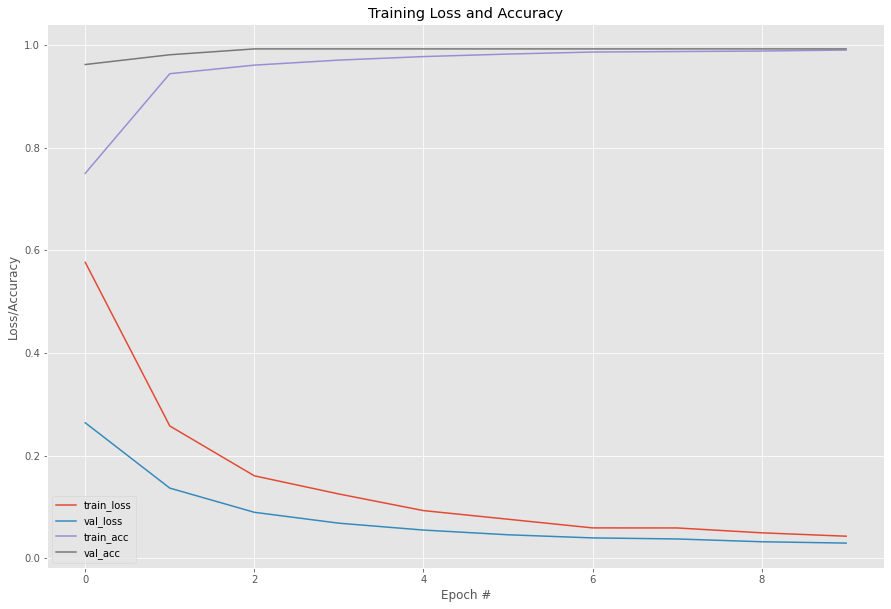

In [18]:
N=EPOCHS
plt.style.use('ggplot')
plt.figure(figsize=(15,10))
plt.plot(np.arange(0,N),H.history["loss"],label = "train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")


In [ ]:
#ACCURACY - 99.2 %